## A practical guide to MCMC 
### Andy Connolly (University of Washington) - ajc@astro.washington.edu
 <br />
### The objectives of this lecture
- A gentle (re)introduction to MCMC (from a mathematical and intuative perspective)
- **An overview of probablistic programming**
- **Hands on exercises using PYMC3 (from fitting a distribution to fitting data of increasing complex likelihoods)**

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import cauchy
import scipy.stats as stats 

from JSAnimation import IPython_display
import pymc3 as pm
import theano as thea
import theano.tensor as T 
%matplotlib inline

## Enough of the lecturing nonsense lets get practical!

###  Software for Markov Chain Monte Carlo

There are two common packages used in MCMC calculations in Astronomy

** emcee **

*The emcee package is a Pure Python package written by Astronomer Dan Foreman-Mackey. It is a lightweight package which implements a fairly sophisticated Affine-invariant Hamiltonian MCMC. Because the package is pure Python (i.e. it contains no compiled extensions) it is extremely easy to install; with pip, simply type at the command-line "pip install emcee".*

*Emcee does not have much specific boilerplate code; it simply requires you to pass it a Python function which returns a value proportional to the log-posterior probability, and returns samples from that posterior.*

All you need to do is define your log-posterior (in Python) and emcee will sample from that distribution. Because it's pure-Python and does not have specially-defined objects for various common distributions (i.e. uniform, normal, etc.) it performs particularly well when the likelihood is expensive to calculate 

** PyMC3 (dont use PYMC2!)**

*The PyMC package has many more features than emcee, including built-in support for efficient sampling of common prior distributions. PyMC by default uses the classic Metropolis-Hastings sampler, one of the earliest MCMC algorithms. PYMC3 is a rewrite of PYMC which improves the API and installation. The hard work in PYMC3 is done through Theano a python package used for Machine Learning. *

More details about PyMC are available from [the pyMC User Guide](https://github.com/pymc-devs/pymc3#id1)

### Probablistic programming: harnessing PYMC3

See "Probabilistic Programming and Bayesian Methods for Hackers" by Cam Davidson for a great introduction


We will start with a simple use case where we take a set of data drawn from a Normal distribution and then fit a Gaussian to these data. In doing so we will outline the details and structure of PYMC3 to prepare use for the exercises later on.

Probablistic distributions can have different forms which are supported by pymc3 using theano (you can also create your own distributions)
- discrete (random variable have distinct values): e.g. Poisson distributions
- continuous (random variable can have arbitrary values): e.g. Exponential distributions
- mixed (can be discrete or continuous): e.g. Gaussian mixtures

As we consider the definition of the priors see Jake vanderPlas's discussion of [how to define non-informative priors](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/)

 


### Fitting a Gaussian to data!

$$p(M,\theta \,|\,D,I) = p(D\,|\,M,\theta, I)\,p(M,\theta\,|\,I)$$

We need to define the model we will be fitting and the distributions that we will use for the priors. For our simple Gaussian example the likelihood will have two parameters, $\mu$, and $\sigma$ and we can assume that these parameters have uniform priors

Likeihood: $p(D\,|\theta) = N(\mu,\sigma)$

Priors: $p(\mu,\sigma)$ as uniform distributions


In [2]:
#generate a set of data
N = 200
np.random.seed(44)
mu_0 = 10.
sigma_0 = 2.
y = np.random.normal(loc=mu_0, scale=sigma_0, size=N)

#set up the model

#length of our chain
nsamples = 2000

with pm.Model() as model: # variables created within a given model's context are assigned to the model 
    #set up the priors for the parameters
    mu = pm.Uniform('mu', lower=-20, upper=20)     # a simple uniform prior
    sigma = pm.Uniform('sigma', lower=0, upper=10)

    #set up the likelihood
    y_obs = pm.Normal('Y_obs', mu, sigma, observed=y) # we use the canned distributions in PYMC3

    #choose our sampling technique
    start = pm.find_MAP() # finds the best starting point, to reduce the burn in time
    step = pm.Metropolis()
    
    trace = pm.sample(nsamples, step, start, random_seed=123, njobs=4, progressbar=True)

         Current function value: 437.975113
         Iterations: 12
         Function evaluations: 100
         Gradient evaluations: 89


100%|██████████| 2500/2500 [00:01<00:00, 1576.39it/s]


### Lets look at the properties of the trace

**Note:** the number of samples is > number requested due to burn in (defaults to 500) and we can run this on multiple cores using the njobs>1 parameter (this is the number of parallel jobs to start)

In [3]:
print(trace)

<MultiTrace: 4 chains, 2000 iterations, 4 variables>


### What do the distributions look like: lets marginalize over parameters by plotting up histograms

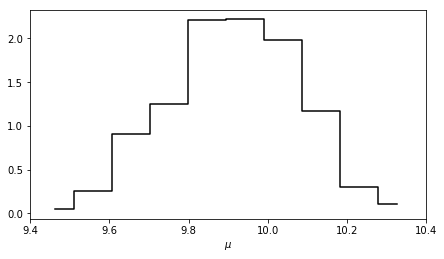

In [4]:
fig = plt.figure(figsize=(10, 10))

hist_mu, bins_mu = np.histogram(trace['mu'], normed=True) # trace['mu'] takes all of the mu values in the chain

ax = fig.add_axes((0.4, 0.1, 0.55, 0.29))
ax.plot(0.5 * (bins_mu[1:] + bins_mu[:-1]), hist_mu,
         '-k', drawstyle='steps-mid')
ax.set_xlabel(r'$\mu$')
plt.xlim(9.4, 10.4)

plt.show()

###  Use PYMC3 tools to do this for us!

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu,9.914680,0.165937,0.006932,9.593520,10.205285
sigma,2.121394,0.101631,0.002712,1.955419,2.325934


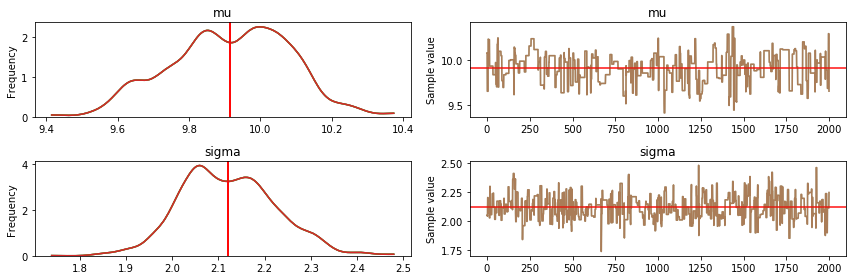

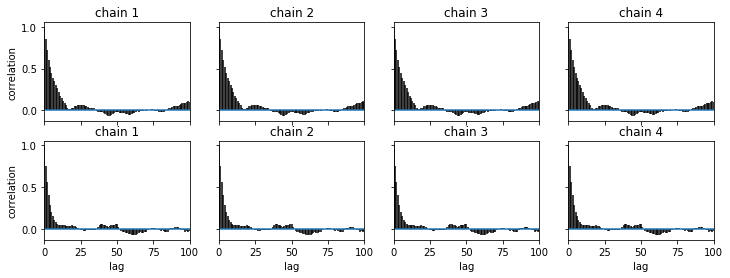

In [5]:
lines = {var:trace[var].mean() for var in trace.varnames}
pm.traceplot(trace, lines= lines)
pm.autocorrplot(trace)
pm.df_summary(trace)

**traceplot** provides
- marginal posterior distribution for each parameter (left)
- the timeseries of the parameter values from the chain (right)

Right hand side shows broad oscillation: both inlying and extreme values occur frequently but at irregular intervals indicating the markov sampler chain was 'well-mixed' (sampling evenly around the optimal position)

**autocorrplot** provides
- correlation between parameters as a function of lag (or separation between steps)
- if you see structure it is showing that the sampler is not travelling the space randomly it depends on the 
    last iteration - features may not be indepdent 

### When to stop

>"Monitoring convergence of iterative simulation is straightforward—discard the first part of the simulations and then compare the variances of quantities of interest within and between chains — and inference given approximate convergence is even simpler; just mix the simulations together and use them as a joint distribution. Both these ideas can and have been refined, but the basic concepts are straightforward and robust.
>
>The hard part is knowing what to do when the simulations are slow to converge."


 > [“Inference from simulations and monitoring convergence” chapter of Handbook of Markov Chain Monte Carlo, Andrew Gelman and Kenneth Shirley](http://www.stat.columbia.edu/~gelman/research/published/GelmanMCMCchapter4.pdf)

** Convergence statistics**

There are a number of proposed statistics for testing convergence

Geweke (1992): Compare the mean of the first fraction and last fraction of a series. The chain is divided into segments and this statistic computed. For convergence the score should vary between -1 and 1.

$$ \frac{E[t_s] - E[t_e]}{\sqrt{V[t_s] + V[t_e]}} $$

with $E[t_s]$ the expaction value and $V[ts]$ the variance of the chain segment

Gelman and Rubin (1992): Compare the variance between multiple chains to the variance within each chain. For convergence between-chain and within-chain variances should be the same. Chains that havent converged have values greater than one. Gelmen and Rubin show that if $\hat{R}$  greater than 1.1 or 1.2 we need longer burn-in.
$$\hat{R} = \frac{\hat{V}}{\hat{W}}$$

with $\hat{W}$ the within chain variance and $\hat{V}$ posterior variance estimate for the pooled traces. 

**Both of these statistics are provided by pymc3**

{'mu': 0.99974996874218502, 'sigma': 0.99974996874218502}

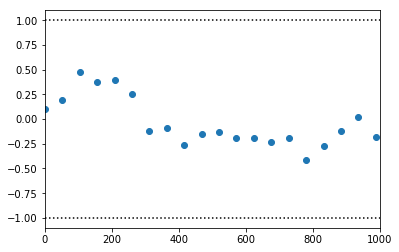

In [6]:
# Geweke diagnostic
g = pm.diagnostics.geweke(trace, intervals=20)
plt.scatter(*g[0]['mu'].T)
plt.hlines([-1,1], 0, 1000, linestyles='dotted')
plt.xlim(0, 1000)

#Gelman-Rubin diagnostic
pm.diagnostics.gelman_rubin(trace)

### Exercise 3: Fit a Cauchy function to data

Repeat the example for the Gaussian but now fit to the data below a Cauchy distribution. Start by defining your own 
priors, set up your likelihood function, choose your sampling technique and build your PYMC model. The two cells below this one provide some plotting routines for showing the marginals of the trace (feel free to use your own - e.g. using seaborn pairgrid)

The Cauchy distribution is given by (two parameters $\gamma$, and $\mu$) and is often used because of its long tailed distributions

$$\frac {1}{\pi \gamma \,\left[1+\left({\frac {x-\mu}{\gamma }}\right)^{2}\right]}$$

<img src="figures/cauchy_distribution.png" alt="cauchy" style="width:600px;"/>

**Describe what happens as you reduce the number of samples**
- for example look at the Gelman-Rubin statistic as you reduce the sample size 

In [26]:
#using PYMC3 to fit Cauchy distribution

# generate observed data
N = 50
np.random.seed(44)
mu_0 = 0
gamma_0 = 2
y = cauchy(mu_0, gamma_0).rvs(N)

nsamples = 2000
with pm.Model() as model:
    #define the priors
    mu = pm.Uniform('mu', lower=-20, upper=20)     # a simple uniform prior
    gamma = pm.Uniform('gamma', lower=0, upper=10)
    
    # define likelihood 
    y_obs = pm.Cauchy('Y_obs', mu, gamma, observed=y)
    
    #inference
    start = pm.find_MAP() # finds the best starting point, to reduce the burn in time
    step = pm.Metropolis()
    
    trace = pm.sample(nsamples, step, start, random_seed=123, njobs=3, progressbar=True)



Optimization terminated successfully.
         Current function value: 163.770055
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12


100%|██████████| 2500/2500 [00:01<00:00, 1439.67it/s]


In [27]:
def convert_to_stdev(logL):
    '''
    Given a grid of log-likelihood values, convert them to cumulative
    standard deviation.  This is useful for drawing contours from a
    grid of likelihoods.
    '''
    sigma = np.exp(logL)

    shape = sigma.shape
    sigma = sigma.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(sigma)[::-1]
    i_unsort = np.argsort(i_sort)

    sigma_cumsum = sigma[i_sort].cumsum()
    sigma_cumsum /= sigma_cumsum[-1]

    return sigma_cumsum[i_unsort].reshape(shape)



def plotDistributionsMarginals (trace_x, trace_y, xlim=(-5,5), ylim=(0,5), nbins=41):
    '''Given a set of traces plot the pairwise distributions'''

    bins=(np.linspace(xlim[0], xlim[1], 41), np.linspace(ylim[0], ylim[1], nbins))
    # compute histogram of results to plot below
    L_MCMC, trace_x_bins, trace_y_bins = np.histogram2d(trace_x, trace_y, bins=bins)
    L_MCMC[L_MCMC == 0] = 1E-16  # prevents zero-division errors

    hist_x, bins_x = np.histogram(trace_x, bins=trace_x_bins, normed=True)
    hist_y, bins_y = np.histogram(trace_y, bins=trace_y_bins, normed=True)


    # first axis: likelihood contours
    ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
    ax1.xaxis.set_major_formatter(plt.NullFormatter())
    ax1.yaxis.set_major_formatter(plt.NullFormatter())
    ax1.contour(0.5 * (trace_x_bins[:-1] + trace_x_bins[1:]),
            0.5 * (trace_y_bins[:-1] + trace_y_bins[1:]),
            convert_to_stdev(np.log(L_MCMC.T)),
            levels=(0.683, 0.955, 0.997),
            colors='k')

    # second axis: marginalized over x
    ax2 = fig.add_axes((0.1, 0.4, 0.29, 0.55))
    ax2.xaxis.set_major_formatter(plt.NullFormatter())
    ax2.plot(hist_y, 0.5 * (bins_y[1:] + bins_y[:-1]
                            - bins_y[1] + bins_y[0]), '-k', drawstyle='steps')
    ax2.set_ylabel(r'$Parameter\ x$')
    ax2.set_ylim(ylim[0], ylim[1])

    # third axis: marginalized over y
    ax3 = fig.add_axes((0.4, 0.1, 0.55, 0.29))
    ax3.yaxis.set_major_formatter(plt.NullFormatter())
    ax3.plot(0.5 * (bins_x[1:] + bins_x[:-1]), hist_x, '-k', drawstyle='steps-mid')
    ax3.set_xlabel(r'$Parameter\ y$')
    plt.xlim(xlim[0], xlim[1])



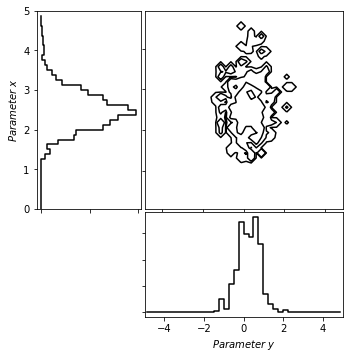

In [28]:
fig = plt.figure(figsize=(5, 5))
plotDistributionsMarginals (trace['mu'], trace['gamma'])


### Lets go further and extend our analysis to other models 

Lets start with regression (infer the expectation value of $y$ given $x$, i.e., the conditional expectation
value). We have all seen the classical maximum likelihood approach for this but we can we can easily use the Bayesian methodology seen earlier this week to write the posterior pdf for the model parameters

$$p({\theta}|x,y,I) \propto p(x,y | {\theta}, I) \,
p({\theta}, I)$$

Here the information $I$ describes the error behavior for the dependent
variable. If the $y$ error distribution is
Gaussian, with the width for $i$th data point given by $\sigma_i$,
and the errors on $x$ are negligible,  then 

$$ p(y_i|x_i,{\theta}, I) =  {1 \over \sigma_i \sqrt{2\pi}} \, \exp{\left({-[y_i-f(x_i|{\theta})]^2 \over 2 \sigma_i^2}\right)} $$

**So y is a random variable with a normal distribution with a mean predicted by the model. We estimate the posterior for the model parameters as well as the variance in the data (also a probablity distribution)**

## Lets start with a simple linear regression 

$$y_i =\theta_0 + \theta_1x_{i1} + \epsilon_i$$

and fit the parameters $\theta_1$ and $\theta_0$

we will initially assume that there are homoskedastic errors (all points have the same error) and will learn this error as part of the model


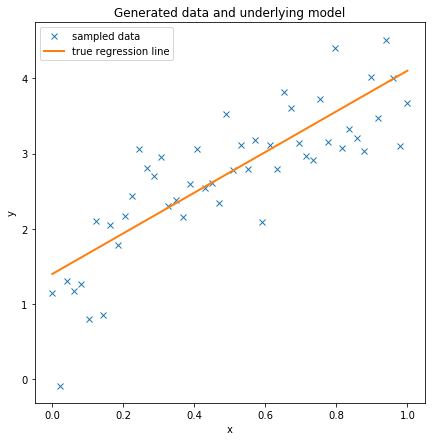

In [8]:
size = 50
intercept = 1.4
slope = 2.7

x = np.linspace(0, 1, size)

# y = a + b*x
model_y = intercept + slope * x

# add noise
y_err = np.random.normal(scale=.5, size=size)
y = model_y + y_err
data = dict(x=x, y=y)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, model_y, label='true regression line', lw=2.)
plt.legend(loc=0)

### Do it yourself regression using PYMC

Optimization terminated successfully.
         Current function value: 44.554660
         Iterations: 12
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 1500/1500 [00:02<00:00, 505.62it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114178198>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x116416dd8>]], dtype=object)

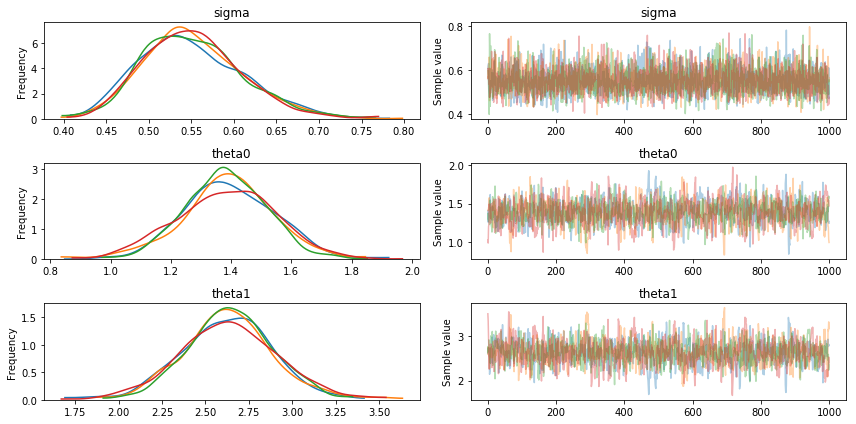

In [9]:
nsample = 1000

with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfNormal('sigma', sd=10)
    theta0 = pm.Uniform('theta0', lower=0, upper=5)
    theta1 = pm.Uniform('theta1', lower=0, upper=5)

    # Define likelihood
    likelihood = pm.Normal('y', mu=theta0 + theta1*x, \
                        sd=sigma, observed=y)   
    # Inference
    start = pm.find_MAP() # Find starting value by optimization
    step = pm.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = pm.sample(nsample, step, start=start, progressbar=True, njobs=4) # run with 4 cores

pm.traceplot(trace)

In [10]:
pm.df_summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
sigma,0.551436,0.058986,0.000916,0.446594,0.673018
theta0,1.386928,0.151858,0.004365,1.083946,1.684101
theta1,2.632262,0.263127,0.007764,2.113161,3.149850


### Now lets plot the predictive posterior samples to see how the distributions of fits varies

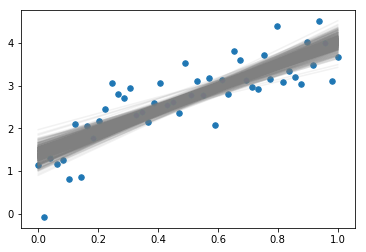

In [11]:
### Plot the predictive posterior samples
plt.scatter(x, y, s=30, label='data')
for a_, b_ in zip(trace['theta1'][-500:], trace['theta0'][-500:]):
    plt.plot(x, a_*x +b_, c='gray', alpha=0.1)

### PYMC3 makes the model fitting easier with the GLM (generalized linear models) package

Very similar to the example before except we express the model using the [patsy](http://patsy.readthedocs.io/en/latest/overview.html) Python package (which can easily describe statistical models and create the associated design matrix)

patsy is a Python package for describing statistical models (especially linear models, or models that have a linear component) and building design matrices (the syntax is borrowed from R). For example

<img src="figures/formula-structure.png" alt="patsy" style="width:600px;"/>





$$y \sim np.power(x, 2) + x$$

Would generate a model for a polynomial regression that included x$^2$, x, and an intercept **Note** the intercepts are not specified within the model 

For our linear model the Patsy formula is y~x. glm() parses the  model, adds the random variables (slope and intercept), creates a likelihood (Normal distribution is default), and adds other variables (e.g. sigma). glm() also initializes the parameters (e.g. what find_MAP() had previously done).

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 10476/10500 [00:14<00:00, 742.26it/s]/anaconda/envs/DSFP/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.879453012543, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 10500/10500 [00:14<00:00, 736.89it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1108cc9b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x115b94cc0>]], dtype=object)

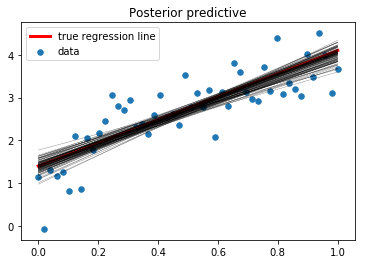

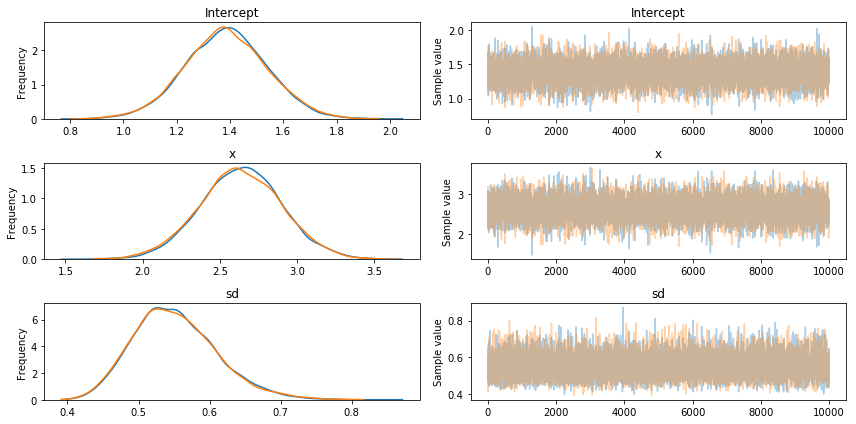

In [12]:
#Using GLM to fit a linear model
nsamples = 10000
with pm.Model() as model:
    pm.glm.GLM.from_formula('y ~ x', data) 
    step = pm.NUTS()
    trace = pm.sample(nsamples, njobs=2)
    
plt.scatter(x, y, s=30, label='data')
plt.plot(x, slope*x + intercept, label='true regression line', lw=3., c='red')
plt.legend(loc='best')

pm.plot_posterior_predictive_glm(trace, samples=100, 
                                 label='posterior predictive regression lines')
pm.traceplot(trace)

### Regression with uncertainities 

We can now extend the examples to include uncertainties within the data. For this we will use the [Hogg, Bovy, and Lang](https://arxiv.org/abs/1008.4686) data set and base our answers on the [notebooks](https://github.com/pymc-devs/pymc3/blob/master/docs/source/notebooks/) in the pymc3 repository


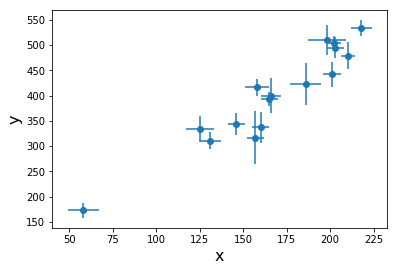

In [13]:
#read in the Hogg data (initially exclude the 4 outlier data points)
data = np.load('hoggData.npy')
x = data['x'][4:]
y = data['y'][4:]
sigma_x = data['sigma_x'][4:]
sigma_y = data['sigma_y'][4:]
plt.scatter(x, y, c='k', s=9)
plt.errorbar(x, y, yerr=sigma_y, xerr=sigma_x, fmt='o')
plt.xlabel('x',fontsize=16)
plt.ylabel('y',fontsize=16)

### Exercise 4: build a regression model for the Hogg data

Repeat the earlier analysis and learn the variance of the data

Optimization terminated successfully.
         Current function value: 93.445945
         Iterations: 32
         Function evaluations: 40
         Gradient evaluations: 40


100%|██████████| 2500/2500 [00:03<00:00, 673.83it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1224f4be0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11c9840f0>]], dtype=object)

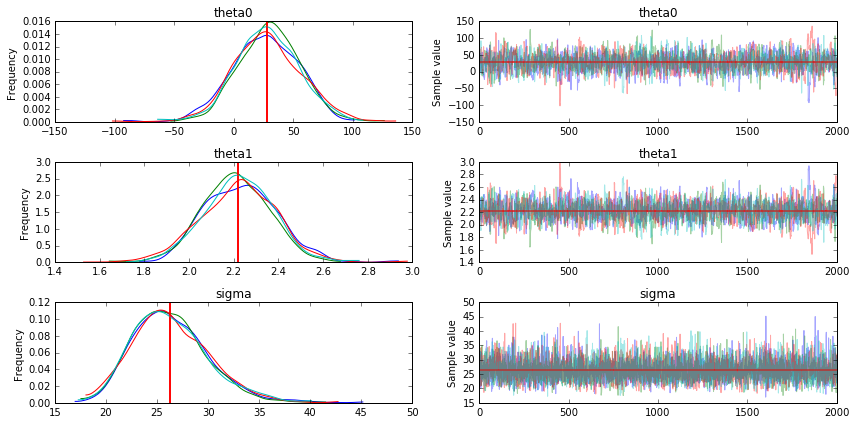

In [17]:
nsample=2000
with pm.Model() as model:
    ## Define weakly informative Normal priors to give Ridge regression
    pm.glm.GLM.from_formula('y ~ x', data) # ??? no clue on how to do this
    
    ## Define linear model
    
    ## Define Normal likelihood
    
    # Inference!
    start = pm.find_MAP() # Find starting value by optimization
    step = pm.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = pm.sample(nsample, step, start=start, progressbar=True, njobs=4) # run with 4 cores

    
lines = {var:trace[var].mean() for var in trace.varnames}
pm.traceplot(trace, lines=lines)

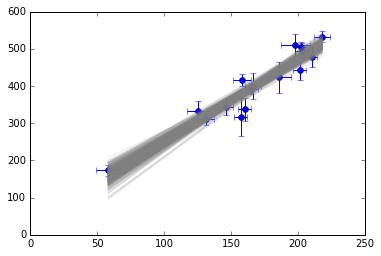

In [18]:
plt.scatter(x, y, c='k', s=9)
plt.errorbar(x, y, yerr=sigma_y, xerr=sigma_x, fmt='o')
for a_, b_ in zip(trace['theta1'][-500:], trace['theta0'][-500:]):
    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)

### Now lets incorporate uncertainties from the data points themselves

Optimization terminated successfully.
         Current function value: 85.410730
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9


100%|██████████| 1500/1500 [00:03<00:00, 380.86it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1169fec18>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x113e2e470>]], dtype=object)

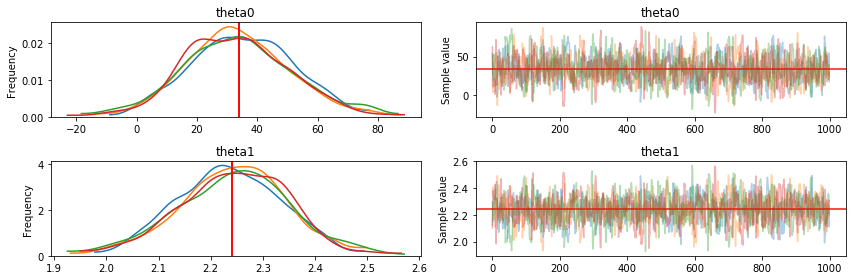

In [14]:
#repeat using y errors
nsample=1000
with pm.Model() as model:
    ## Define weakly informative Normal priors to give Ridge regression
    theta0 = pm.Normal('theta0', mu=0, sd=100) # why normal
    theta1 = pm.Normal('theta1', mu=0, sd=100)

    ## Define linear model
    yest = theta0 +  theta1* x
    
    ## Use y error from dataset, convert into theano variable
    thea_sigma_y = thea.shared(np.asarray(sigma_y, dtype=thea.config.floatX), name='sigma_y')

    ## Define Normal likelihood
    likelihood = pm.Normal('likelihood', mu=yest, sd=thea_sigma_y, observed=y)    

    # Inference!
    start = pm.find_MAP() # Find starting value by optimization
    step = pm.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = pm.sample(nsample, step, start=start, progressbar=True, njobs=4) # run with 4 cores

lines = {var:trace[var].mean() for var in trace.varnames}
pm.traceplot(trace, lines=lines)

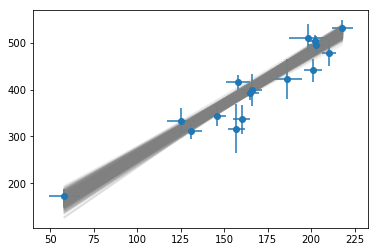

In [15]:
plt.scatter(x, y, c='k', s=9)
plt.errorbar(x, y, yerr=sigma_y, xerr=sigma_x, fmt='o')
for a_, b_ in zip(trace['theta1'][-500:], trace['theta0'][-500:]):
    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)

### Outlier rejection

The  L2 norm (assuming the likelihood has a normal distribution) is sensitive to outliers (i.e. it squares the residuals). A number of approaches exist for correcting for outliers. These include "sigma-clipping", using interquartile ranges, and taking the median of solutions of subsets of the data

Other approaches include changing the likelihood function to one that allows for longer tails or assuming that the data are drawn from two Gaussians error distribution (one for the function and the other for the outliers)

$\mathcal{logL} = \sum_{i}^{i=N} log \left[ \frac{(1 - B_{i})}{\sqrt{2 \pi \sigma_{in}^{2}}} exp \left( - \frac{(x_{i} - \mu_{in})^{2}}{2\sigma_{in}^{2}} \right) \right] + \sum_{i}^{i=N} log \left[ \frac{B_{i}}{\sqrt{2 \pi (\sigma_{in}^{2} + \sigma_{out}^{2})}} exp \left( - \frac{(x_{i}- \mu_{out})^{2}}{2(\sigma_{in}^{2} + \sigma_{out}^{2})} \right) \right]$

where:

$\bf{B}$ is Bernoulli-distibuted $B_{i} \in [0_{(inlier)},1_{(outlier)}]$

If we use MCMC we can marginalize over the nuisance parameters  $B$ ,  $\sigma_{out}$, $\mu_{out}$. We could also calculate the probability that a point is drawn from the outlier or "model" Gaussian.

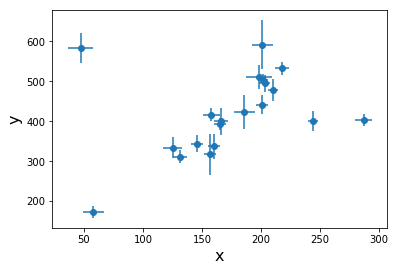

In [16]:
x = data['x']
y = data['y']
sigma_x = data['sigma_x']
sigma_y = data['sigma_y']
plt.scatter(x, y, c='k', s=9)
plt.errorbar(x, y, yerr=sigma_y, xerr=sigma_x, fmt='o')
plt.xlabel('x',fontsize=16)
plt.ylabel('y',fontsize=16)

Optimization terminated successfully.
         Current function value: 240.575175
         Iterations: 8
         Function evaluations: 11
         Gradient evaluations: 11


100%|██████████| 2500/2500 [00:05<00:00, 474.86it/s]


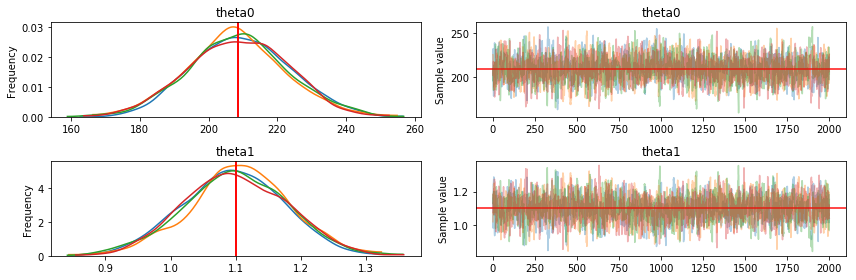

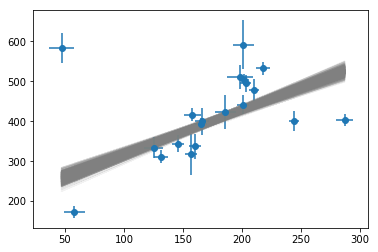

In [17]:
nsample=2000
with pm.Model() as model:
    ## Define weakly informative Normal priors to give Ridge regression
    theta0 = pm.Normal('theta0', mu=0, sd=100)
    theta1 = pm.Normal('theta1', mu=0, sd=100)

    ## Define linear model
    yest = theta0 +  theta1* x
    
    # Use y error from dataset, convert into theano variable
    thea_sigma_y = thea.shared(np.asarray(sigma_y, dtype=thea.config.floatX), name='sigma_y')

    ## Define Normal likelihood
    likelihood = pm.Normal('likelihood', mu=yest, sd=thea_sigma_y, observed=y)    

    # Inference!
    start = pm.find_MAP() # Find starting value by optimization
    step = pm.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = pm.sample(nsample, step, start=start, progressbar=True, njobs=4) # run with 4 cores

lines = {var:trace[var].mean() for var in trace.varnames}
pm.traceplot(trace, lines=lines)

plt.figure()
plt.scatter(x, y, c='k', s=9)
plt.errorbar(x, y, yerr=sigma_y, xerr=sigma_x, fmt='o')
for a_, b_ in zip(trace['theta1'][-500:], trace['theta0'][-500:]):
    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)

### Exercise 5: develop a robust regression using likelihood and priors

You have seen the example of the Huber loss function. When we use a normal likelihood function excursions are weighted heavily (by the square of the deviation). If we consider that the distribution of residuals is not described by a Gaussian come up with a way to reduce the impact of outliers in the model fit

In [31]:
#robust regression
nsample=2000
with pm.Model() as model:
    ## Define weakly informative Normal priors to give Ridge regression
    theta0 = pm.Normal('theta0', mu=0, sd=100)
    theta1 = pm.Normal('theta1', mu=0, sd=100)

    ## Define linear model
    yest = theta0 +  theta1* x
    
    ## Use y error from dataset, convert into theano variable
    thea_sigma_y = thea.shared(np.asarray(sigma_y, dtype=thea.config.floatX), name='sigma_y')

    ## Define the likelihood
    likelihood = pm.Cauchy('Likelihood',theta0, theta1, observed=y)  # Use a Cauchy but modify these inputs pm.Cauchy('Y_obs', mu, gamma, observed=y)
    
    # Inference
    trace = pm.sample(nsample, step, start=start, progressbar=True, njobs=4) # run with 4 cores

lines = {var:trace[var].mean() for var in trace.varnames}
pm.traceplot(trace, lines=lines)

plt.figure()
plt.scatter(x, y, c='k', s=9)
plt.errorbar(x, y, yerr=sigma_y, xerr=sigma_x, fmt='o')
for a_, b_ in zip(trace['theta1'][-500:], trace['theta0'][-500:]):
    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)

/anaconda/envs/DSFP/lib/python3.6/site-packages/pymc3/distributions/continuous.py:68: UserWarning: The variable specified for beta has negative support for Cauchy, likely making it unsuitable for this parameter.
  warnings.warn(msg)
Assigned NUTS to theta0
Assigned NUTS to theta1
  0%|          | 0/2500 [00:00<?, ?it/s]


JoblibKeyError: JoblibKeyError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/anaconda/envs/DSFP/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x101b23d20, file "/ana...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/anaconda/envs/DSFP/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/anaconda/envs/DSFP/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/anaconda/en.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x101b23d20, file "/ana...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/anaconda/envs/DSFP/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/anaconda/envs/DSFP/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/anaconda/en.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "#robust regression\nnsample=2000\nwith pm.Model() ...:\n    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 9, 19, 23, 16, 53, 705646, tzinfo=tzutc()), 'msg_id': 'F1278907CDFE41A88D79E31BA36933B4', 'msg_type': 'execute_request', 'session': '637FB265EB39452888528BF7494DA357', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'F1278907CDFE41A88D79E31BA36933B4', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'637FB265EB39452888528BF7494DA357']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "#robust regression\nnsample=2000\nwith pm.Model() ...:\n    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 9, 19, 23, 16, 53, 705646, tzinfo=tzutc()), 'msg_id': 'F1278907CDFE41A88D79E31BA36933B4', 'msg_type': 'execute_request', 'session': '637FB265EB39452888528BF7494DA357', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'F1278907CDFE41A88D79E31BA36933B4', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'637FB265EB39452888528BF7494DA357'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "#robust regression\nnsample=2000\nwith pm.Model() ...:\n    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 9, 19, 23, 16, 53, 705646, tzinfo=tzutc()), 'msg_id': 'F1278907CDFE41A88D79E31BA36933B4', 'msg_type': 'execute_request', 'session': '637FB265EB39452888528BF7494DA357', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'F1278907CDFE41A88D79E31BA36933B4', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="#robust regression\nnsample=2000\nwith pm.Model() ...:\n    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "#robust regression\nnsample=2000\nwith pm.Model() ...:\n    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)"
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("#robust regression\nnsample=2000\nwith pm.Model() ...:\n    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)",), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("#robust regression\nnsample=2000\nwith pm.Model() ...:\n    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)",)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="#robust regression\nnsample=2000\nwith pm.Model() ...:\n    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)", store_history=True, silent=False, shell_futures=True)
   2693                 self.displayhook.exec_result = result
   2694 
   2695                 # Execute the user code
   2696                 interactivity = "none" if silent else self.ast_node_interactivity
   2697                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2698                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2699                 
   2700                 self.last_execution_succeeded = not has_raised
   2701 
   2702                 # Reset this so later displayed values do not modify the

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.With object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.For object>], cell_name='<ipython-input-31-fd4178a7ab44>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 10f9b95f8, execution_..._before_exec=None error_in_exec=None result=None>)
   2797 
   2798         try:
   2799             for i, node in enumerate(to_run_exec):
   2800                 mod = ast.Module([node])
   2801                 code = compiler(mod, cell_name, "exec")
-> 2802                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x1162d75d0, file "<ipython-input-31-fd4178a7ab44>", line 3>
        result = <ExecutionResult object at 10f9b95f8, execution_..._before_exec=None error_in_exec=None result=None>
   2803                     return True
   2804 
   2805             for i, node in enumerate(to_run_interactive):
   2806                 mod = ast.Interactive([node])

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x1162d75d0, file "<ipython-input-31-fd4178a7ab44>", line 3>, result=<ExecutionResult object at 10f9b95f8, execution_..._before_exec=None error_in_exec=None result=None>)
   2857         outflag = True  # happens in more places, so it's easier as default
   2858         try:
   2859             try:
   2860                 self.hooks.pre_run_code_hook()
   2861                 #rprint('Running code', repr(code_obj)) # dbg
-> 2862                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x1162d75d0, file "<ipython-input-31-fd4178a7ab44>", line 3>
        self.user_global_ns = {'IPython_display': <module 'JSAnimation.IPython_display' from '/ana....6/site-packages/JSAnimation/IPython_display.py'>, 'In': ['', "import numpy as np\nfrom matplotlib import pyplot...or as T \nget_ipython().magic('matplotlib inline')", '#generate a set of data\nN = 200\nnp.random.seed(4...tart, random_seed=123, njobs=4, progressbar=True)', 'print(trace)', "fig = plt.figure(figsize=(10, 10))\n\nhist_mu, bin..._xlabel(r'$\\mu$')\nplt.xlim(9.4, 10.4)\n\nplt.show()", 'lines = {var:trace[var].mean() for var in trace....ines)\npm.autocorrplot(trace)\npm.df_summary(trace)', '# Geweke diagnostic\ng = pm.diagnostics.geweke(tr...bin diagnostic\npm.diagnostics.gelman_rubin(trace)', '#using PYMC3 to fit Cauchy distribution\n\n# gener...tart, random_seed=123, njobs=3, progressbar=True)', "size = 50\nintercept = 1.4\nslope = 2.7\n\nx = np.li...='true regression line', lw=2.)\nplt.legend(loc=0)", 'nsample = 1000\n\nwith pm.Model() as model: # mode... njobs=4) # run with 4 cores\n\npm.traceplot(trace)', 'pm.df_summary(trace)', "### Plot the predictive posterior samples\nplt.sc...):\n    plt.plot(x, a_*x +b_, c='gray', alpha=0.1)", "#Using GLM to fit a linear model\nnsamples = 1000...predictive regression lines')\npm.traceplot(trace)", "#read in the Hogg data (initially exclude the 4 ...abel('x',fontsize=16)\nplt.ylabel('y',fontsize=16)", '#repeat using y errors\nnsample=1000\nwith pm.Mode... trace.varnames}\npm.traceplot(trace, lines=lines)', "plt.scatter(x, y, c='k', s=9)\nplt.errorbar(x, y,...:\n    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)", "x = data['x']\ny = data['y']\nsigma_x = data['sigm...abel('x',fontsize=16)\nplt.ylabel('y',fontsize=16)", "nsample=2000\nwith pm.Model() as model:\n    ## De...:\n    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)", '#using PYMC3 to fit Cauchy distribution\n\n# gener...tart, random_seed=123, njobs=3, progressbar=True)', "def convert_to_stdev(logL):\n    '''\n    Given a ...r'$Parameter\\ y$')\n    plt.xlim(xlim[0], xlim[1])", ...], 'N': 50, 'Out': {5:            mean        sd  mc_error   hpd_2.5   ...2.121394  0.101631  0.002712  1.955419   2.325934, 6: {'mu': 0.99974996874218502, 'sigma': 0.99974996874218502}, 8: <matplotlib.legend.Legend object>, 9: array([[<matplotlib.axes._subplots.AxesSubplot o...esSubplot object at 0x116416dd8>]], dtype=object), 10:             mean        sd  mc_error   hpd_2.5  ... 2.632262  0.263127  0.007764  2.113161  3.149850, 12: array([[<matplotlib.axes._subplots.AxesSubplot o...esSubplot object at 0x115b94cc0>]], dtype=object), 13: <matplotlib.text.Text object>, 14: array([[<matplotlib.axes._subplots.AxesSubplot o...esSubplot object at 0x113e2e470>]], dtype=object), 16: <matplotlib.text.Text object>}, 'T': <module 'theano.tensor' from '/anaconda/envs/DSF...thon3.6/site-packages/theano/tensor/__init__.py'>, '_': <matplotlib.text.Text object>, '_10':             mean        sd  mc_error   hpd_2.5  ... 2.632262  0.263127  0.007764  2.113161  3.149850, '_12': array([[<matplotlib.axes._subplots.AxesSubplot o...esSubplot object at 0x115b94cc0>]], dtype=object), '_13': <matplotlib.text.Text object>, '_14': array([[<matplotlib.axes._subplots.AxesSubplot o...esSubplot object at 0x113e2e470>]], dtype=object), ...}
        self.user_ns = {'IPython_display': <module 'JSAnimation.IPython_display' from '/ana....6/site-packages/JSAnimation/IPython_display.py'>, 'In': ['', "import numpy as np\nfrom matplotlib import pyplot...or as T \nget_ipython().magic('matplotlib inline')", '#generate a set of data\nN = 200\nnp.random.seed(4...tart, random_seed=123, njobs=4, progressbar=True)', 'print(trace)', "fig = plt.figure(figsize=(10, 10))\n\nhist_mu, bin..._xlabel(r'$\\mu$')\nplt.xlim(9.4, 10.4)\n\nplt.show()", 'lines = {var:trace[var].mean() for var in trace....ines)\npm.autocorrplot(trace)\npm.df_summary(trace)', '# Geweke diagnostic\ng = pm.diagnostics.geweke(tr...bin diagnostic\npm.diagnostics.gelman_rubin(trace)', '#using PYMC3 to fit Cauchy distribution\n\n# gener...tart, random_seed=123, njobs=3, progressbar=True)', "size = 50\nintercept = 1.4\nslope = 2.7\n\nx = np.li...='true regression line', lw=2.)\nplt.legend(loc=0)", 'nsample = 1000\n\nwith pm.Model() as model: # mode... njobs=4) # run with 4 cores\n\npm.traceplot(trace)', 'pm.df_summary(trace)', "### Plot the predictive posterior samples\nplt.sc...):\n    plt.plot(x, a_*x +b_, c='gray', alpha=0.1)", "#Using GLM to fit a linear model\nnsamples = 1000...predictive regression lines')\npm.traceplot(trace)", "#read in the Hogg data (initially exclude the 4 ...abel('x',fontsize=16)\nplt.ylabel('y',fontsize=16)", '#repeat using y errors\nnsample=1000\nwith pm.Mode... trace.varnames}\npm.traceplot(trace, lines=lines)', "plt.scatter(x, y, c='k', s=9)\nplt.errorbar(x, y,...:\n    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)", "x = data['x']\ny = data['y']\nsigma_x = data['sigm...abel('x',fontsize=16)\nplt.ylabel('y',fontsize=16)", "nsample=2000\nwith pm.Model() as model:\n    ## De...:\n    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)", '#using PYMC3 to fit Cauchy distribution\n\n# gener...tart, random_seed=123, njobs=3, progressbar=True)', "def convert_to_stdev(logL):\n    '''\n    Given a ...r'$Parameter\\ y$')\n    plt.xlim(xlim[0], xlim[1])", ...], 'N': 50, 'Out': {5:            mean        sd  mc_error   hpd_2.5   ...2.121394  0.101631  0.002712  1.955419   2.325934, 6: {'mu': 0.99974996874218502, 'sigma': 0.99974996874218502}, 8: <matplotlib.legend.Legend object>, 9: array([[<matplotlib.axes._subplots.AxesSubplot o...esSubplot object at 0x116416dd8>]], dtype=object), 10:             mean        sd  mc_error   hpd_2.5  ... 2.632262  0.263127  0.007764  2.113161  3.149850, 12: array([[<matplotlib.axes._subplots.AxesSubplot o...esSubplot object at 0x115b94cc0>]], dtype=object), 13: <matplotlib.text.Text object>, 14: array([[<matplotlib.axes._subplots.AxesSubplot o...esSubplot object at 0x113e2e470>]], dtype=object), 16: <matplotlib.text.Text object>}, 'T': <module 'theano.tensor' from '/anaconda/envs/DSF...thon3.6/site-packages/theano/tensor/__init__.py'>, '_': <matplotlib.text.Text object>, '_10':             mean        sd  mc_error   hpd_2.5  ... 2.632262  0.263127  0.007764  2.113161  3.149850, '_12': array([[<matplotlib.axes._subplots.AxesSubplot o...esSubplot object at 0x115b94cc0>]], dtype=object), '_13': <matplotlib.text.Text object>, '_14': array([[<matplotlib.axes._subplots.AxesSubplot o...esSubplot object at 0x113e2e470>]], dtype=object), ...}
   2863             finally:
   2864                 # Reset our crash handler in place
   2865                 sys.excepthook = old_excepthook
   2866         except SystemExit as e:

...........................................................................
/Users/eileengonzales/Dropbox/LSSTC_DSFP/LSSTC-DSFP-Sessions/Session4/Day2/<ipython-input-31-fd4178a7ab44> in <module>()
     13 
     14     ## Define the likelihood
     15     likelihood = pm.Cauchy('Likelihood',theta0, theta1, observed=y)  # Use a Cauchy but modify these inputs pm.Cauchy('Y_obs', mu, gamma, observed=y)
     16     
     17     # Inference
---> 18     trace = pm.sample(nsample, step, start=start, progressbar=True, njobs=4) # run with 4 cores
     19 
     20 lines = {var:trace[var].mean() for var in trace.varnames}
     21 pm.traceplot(trace, lines=lines)
     22 

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/pymc3/sampling.py in sample(draws=2500, step=[<pymc3.step_methods.compound.CompoundStep object>, <pymc3.step_methods.hmc.nuts.NUTS object>], init='auto', n_init=200000, start={'gamma': array(2.294720194923718), 'gamma_interval__': array(-1.2112948661967946), 'mu': array(0.26779050647231983), 'mu_interval__': array(0.026780651130002796)}, trace=None, chain=0, njobs=4, tune=500, nuts_kwargs=None, step_kwargs=None, progressbar=True, model=<pymc3.model.Model object>, random_seed=-1, live_plot=False, discard_tuned_samples=True, live_plot_kwargs=None, **kwargs={})
    281     else:
    282         sample_func = _sample
    283 
    284     discard = tune if discard_tuned_samples else 0
    285 
--> 286     return sample_func(**sample_args)[discard:]
        sample_func = <function _mp_sample>
        sample_args = {'chain': 0, 'draws': 2500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'njobs': 4, 'progressbar': True, 'random_seed': -1, 'start': {'gamma': array(2.294720194923718), 'gamma_interval__': array(-1.2112948661967946), 'mu': array(0.26779050647231983), 'mu_interval__': array(0.026780651130002796)}, 'step': [<pymc3.step_methods.compound.CompoundStep object>, <pymc3.step_methods.hmc.nuts.NUTS object>], ...}
        discard = 500
    287 
    288 
    289 def _check_start_shape(model, start):
    290     e = ''

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/pymc3/sampling.py in _mp_sample(**kwargs={'draws': 2500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': [<pymc3.step_methods.compound.CompoundStep object>, <pymc3.step_methods.hmc.nuts.NUTS object>], 'trace': None, 'tune': 500})
    499     pbars = [kwargs.pop('progressbar')] + [False] * (njobs - 1)
    500     traces = Parallel(n_jobs=njobs)(delayed(_sample)(chain=chains[i],
    501                                                      progressbar=pbars[i],
    502                                                      random_seed=rseed[i],
    503                                                      start=start_vals[i],
--> 504                                                      **kwargs) for i in range(njobs))
        kwargs = {'draws': 2500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': [<pymc3.step_methods.compound.CompoundStep object>, <pymc3.step_methods.hmc.nuts.NUTS object>], 'trace': None, 'tune': 500}
        njobs = 4
    505     return merge_traces(traces)
    506 
    507 
    508 def stop_tuning(step):

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=4), iterable=<generator object _mp_sample.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=4)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
KeyError                                           Tue Sep 19 16:16:57 2017
PID: 10976                     Python 3.6.2: /anaconda/envs/DSFP/bin/python
...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _sample>, (), {'chain': 0, 'draws': 2500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'progressbar': True, 'random_seed': 1519053686, 'start': {'gamma': array(2.294720194923718), 'gamma_interval__': array(-1.2112948661967946), 'mu': array(0.26779050647231983), 'mu_interval__': array(0.026780651130002796), 'theta0': array(0.0), 'theta1': array(0.0)}, 'step': [<pymc3.step_methods.compound.CompoundStep object>, <pymc3.step_methods.hmc.nuts.NUTS object>], 'trace': None, ...})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _sample>
        args = ()
        kwargs = {'chain': 0, 'draws': 2500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'progressbar': True, 'random_seed': 1519053686, 'start': {'gamma': array(2.294720194923718), 'gamma_interval__': array(-1.2112948661967946), 'mu': array(0.26779050647231983), 'mu_interval__': array(0.026780651130002796), 'theta0': array(0.0), 'theta1': array(0.0)}, 'step': [<pymc3.step_methods.compound.CompoundStep object>, <pymc3.step_methods.hmc.nuts.NUTS object>], 'trace': None, ...}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/pymc3/sampling.py in _sample(draws=2500, step=[<pymc3.step_methods.compound.CompoundStep object>, <pymc3.step_methods.hmc.nuts.NUTS object>], start={'gamma': array(2.294720194923718), 'gamma_interval__': array(-1.2112948661967946), 'mu': array(0.26779050647231983), 'mu_interval__': array(0.026780651130002796), 'theta0': array(0.0), 'theta1': array(0.0)}, trace=None, chain=0, tune=500, progressbar=True, model=<pymc3.model.Model object>, random_seed=1519053686, live_plot=False, live_plot_kwargs=None, **kwargs={})
    328                             tune, model, random_seed)
    329     if progressbar:
    330         sampling = tqdm(sampling, total=draws)
    331     try:
    332         strace = None
--> 333         for it, strace in enumerate(sampling):
        it = undefined
        strace = None
        sampling =   0%|          | 0/2500 [00:00<?, ?it/s]
    334             if live_plot:
    335                 if live_plot_kwargs is None:
    336                     live_plot_kwargs = {}
    337                 if it >= skip_first:

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/tqdm/_tqdm.py in __iter__(self=  0%|          | 0/2500 [00:00<?, ?it/s])
    867             except AttributeError:
    868                 raise TqdmDeprecationWarning("""\
    869 Please use `tqdm_gui(...)` instead of `tqdm(..., gui=True)`
    870 """, fp_write=getattr(self.fp, 'write', sys.stderr.write))
    871 
--> 872             for obj in iterable:
        obj = undefined
        iterable = <generator object _iter_sample>
    873                 yield obj
    874                 # Update and print the progressbar.
    875                 # Note: does not call self.update(1) for speed optimisation.
    876                 n += 1

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/pymc3/sampling.py in _iter_sample(draws=2500, step=<pymc3.step_methods.compound.CompoundStep object>, start={'gamma': array(2.294720194923718), 'gamma_interval__': array(-1.2112948661967946), 'mu': array(0.26779050647231983), 'mu_interval__': array(0.026780651130002796), 'theta0': array(0.0), 'theta1': array(0.0)}, trace=None, chain=0, tune=500, model=<pymc3.model.Model object>, random_seed=1519053686)
    426     try:
    427         for i in range(draws):
    428             if i == tune:
    429                 step = stop_tuning(step)
    430             if step.generates_stats:
--> 431                 point, states = step.step(point)
        point = {'theta0': array(0.0), 'theta1': array(0.0)}
        states = undefined
        step.step = <bound method CompoundStep.step of <pymc3.step_methods.compound.CompoundStep object>>
    432                 if strace.supports_sampler_stats:
    433                     strace.record(point, states)
    434                 else:
    435                     strace.record(point)

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/pymc3/step_methods/compound.py in step(self=<pymc3.step_methods.compound.CompoundStep object>, point={'theta0': array(0.0), 'theta1': array(0.0)})
     19     def step(self, point):
     20         if self.generates_stats:
     21             states = []
     22             for method in self.methods:
     23                 if method.generates_stats:
---> 24                     point, state = method.step(point)
        point = {'theta0': array(0.0), 'theta1': array(0.0)}
        state = undefined
        method.step = <bound method CompoundStep.step of <pymc3.step_methods.compound.CompoundStep object>>
     25                     states.extend(state)
     26                 else:
     27                     point = method.step(point)
     28             return point, states

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/pymc3/step_methods/compound.py in step(self=<pymc3.step_methods.compound.CompoundStep object>, point={'theta0': array(0.0), 'theta1': array(0.0)})
     19     def step(self, point):
     20         if self.generates_stats:
     21             states = []
     22             for method in self.methods:
     23                 if method.generates_stats:
---> 24                     point, state = method.step(point)
        point = {'theta0': array(0.0), 'theta1': array(0.0)}
        state = undefined
        method.step = <bound method ArrayStepShared.step of <pymc3.step_methods.metropolis.Metropolis object>>
     25                     states.extend(state)
     26                 else:
     27                     point = method.step(point)
     28             return point, states

...........................................................................
/anaconda/envs/DSFP/lib/python3.6/site-packages/pymc3/step_methods/arraystep.py in step(self=<pymc3.step_methods.metropolis.Metropolis object>, point={'theta0': array(0.0), 'theta1': array(0.0)})
    143         self.shared = {str(var): shared for var, shared in shared.items()}
    144         self.blocked = blocked
    145 
    146     def step(self, point):
    147         for var, share in self.shared.items():
--> 148             share.set_value(point[var])
        share.set_value = <bound method SharedVariable.set_value of mu_interval___shared>
        point = {'theta0': array(0.0), 'theta1': array(0.0)}
        var = 'mu_interval__'
    149 
    150         bij = DictToArrayBijection(self.ordering, point)
    151 
    152         if self.generates_stats:

KeyError: 'mu_interval__'
___________________________________________________________________________

### Modelling outliers

Assume the data are drawn from two Gaussians error distribution (one for the function and the other for the outliers)

$\mathcal{logL} = \sum_{i}^{i=N} log \left[ \frac{(1 - B_{i})}{\sqrt{2 \pi \sigma_{in}^{2}}} exp \left( - \frac{(x_{i} - \mu_{in})^{2}}{2\sigma_{in}^{2}} \right) \right] + \sum_{i}^{i=N} log \left[ \frac{B_{i}}{\sqrt{2 \pi (\sigma_{in}^{2} + \sigma_{out}^{2})}} exp \left( - \frac{(x_{i}- \mu_{out})^{2}}{2(\sigma_{in}^{2} + \sigma_{out}^{2})} \right) \right]$



In [29]:
import theano.tensor as T 
def logp_signoise(yobs, is_outlier, yest_in, sigma_y_in, yest_out, sigma_y_out):
    '''
    Define custom loglikelihood for inliers vs outliers. 
    NOTE: in this particular case we don't need to use theano's @as_op 
    decorator because (as stated by Twiecki in conversation) that's only 
    required if the likelihood cannot be expressed as a theano expression.
    We also now get the gradient computation for free.
    '''   
    
    # likelihood for inliers
    pdfs_in = T.exp(-(yobs - yest_in + 1e-4)**2 / (2 * sigma_y_in**2)) 
    pdfs_in /= T.sqrt(2 * np.pi * sigma_y_in**2)
    logL_in = T.sum(T.log(pdfs_in) * (1 - is_outlier))

    # likelihood for outliers
    pdfs_out = T.exp(-(yobs - yest_out + 1e-4)**2 / (2 * (sigma_y_in**2 + sigma_y_out**2))) 
    pdfs_out /= T.sqrt(2 * np.pi * (sigma_y_in**2 + sigma_y_out**2))
    logL_out = T.sum(T.log(pdfs_out) * is_outlier)

    return logL_in + logL_out

In [30]:
with pm.Model() as mdl_signoise:
    
    ## Define weakly informative Normal priors to give Ridge regression
    theta0 = pm.Normal('theta0', mu=0, sd=10, testval=pm.floatX(0.1))
    theta1 = pm.Normal('theta1', mu=0, sd=10, testval=pm.floatX(1.))
 
    ## Define linear model
    yest_in = theta0 + theta1 * x

    ## Define weakly informative priors for the mean and variance of outliers
    yest_out = pm.Normal('yest_out', mu=0, sd=100, testval=pm.floatX(1.))
    sigma_y_out = pm.HalfNormal('sigma_y_out', sd=100, testval=pm.floatX(1.))

    ## Define Bernoulli inlier / outlier flags according to a hyperprior 
    ## fraction of outliers, itself constrained to [0,.5] for symmetry
    frac_outliers = pm.Uniform('frac_outliers', lower=0., upper=.5)
    is_outlier = pm.Bernoulli('is_outlier', p=frac_outliers, shape=x.shape[0], 
                              testval=np.random.rand(x.shape[0]) < 0.2)
    
    ## Extract observed y and sigma_y from dataset, encode as theano objects
    yobs = thea.shared(np.asarray(y, dtype=thea.config.floatX), name='yobs')
    sigma_y_in = thea.shared(np.asarray(sigma_y, dtype=thea.config.floatX), 
                             name='sigma_y_in')
        
    ## Use custom likelihood using DensityDist
    likelihood = pm.DensityDist('likelihood', logp_signoise,
                        observed={'yobs': yobs, 'is_outlier': is_outlier,
                                  'yest_in': yest_in, 'sigma_y_in': sigma_y_in,
                                  'yest_out': yest_out, 'sigma_y_out': sigma_y_out})

ValueError: Input dimension mis-match. (input[0].shape[0] = 50, input[1].shape[0] = 20)

In [ ]:
with mdl_signoise:
    ## two-step sampling to create Bernoulli inlier/outlier flags
    step1 = pm.Metropolis([frac_outliers, yest_out, sigma_y_out, theta0, theta1])
    step2 = pm.step_methods.BinaryGibbsMetropolis([is_outlier])

    ## take samples
    traces_signoise = pm.sample(20000, step=[step1, step2], tune=10000, progressbar=True)

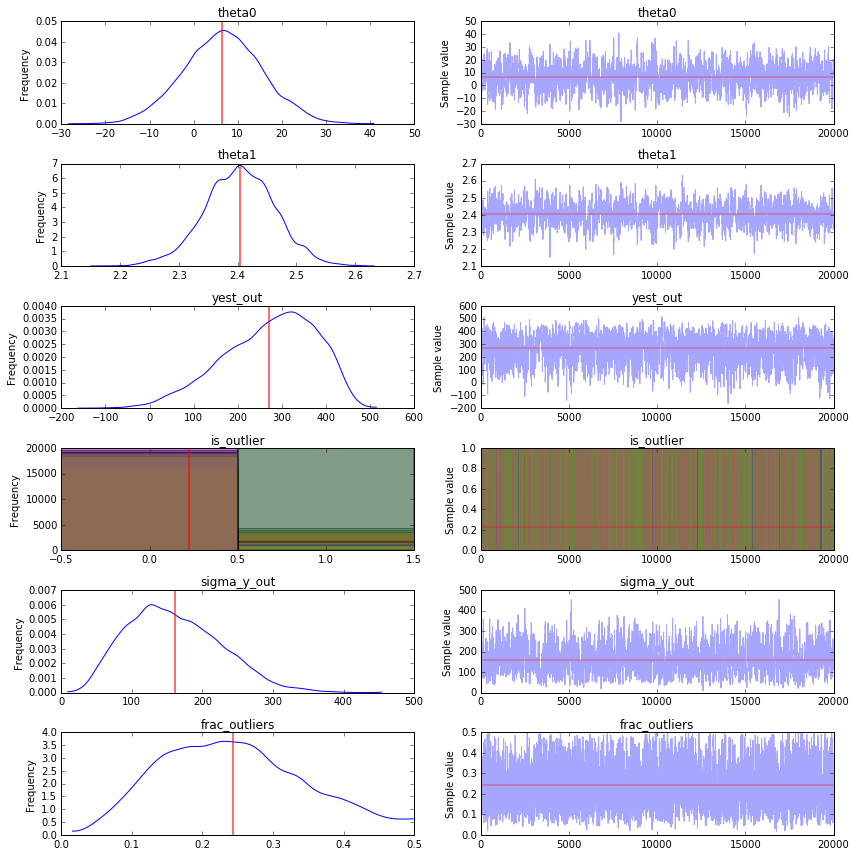

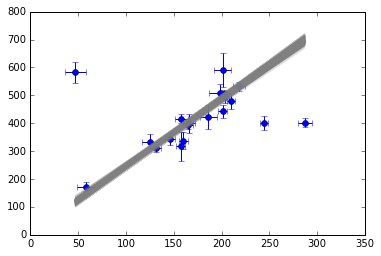

In [41]:
lines = {var:traces_signoise[var].mean() for var in traces_signoise.varnames}
pm.traceplot(traces_signoise, lines=lines)

plt.figure()
plt.scatter(x, y, c='k', s=9)
plt.errorbar(x, y, yerr=sigma_y, xerr=sigma_x, fmt='o')
for a_, b_ in zip(traces_signoise['theta1'][-500:], traces_signoise['theta0'][-500:]):
    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)

For small numbers of data points and large numbers of parameters we run into issues with overfitting. Defining priors on the parameters values (e.g., constraining the absolute or squared distance of the parameters) can alleviate some of these issues. This

For example 

Ridge regression: $p(\theta | I ) \propto \exp{\left(\frac{-(\lambda \theta^T \theta)^2}{2}\right)}$

LASSO regression: $p(\theta | I ) \propto \exp{\left(\frac{-(\lambda \theta^T \theta)}{2}\right)}$

the regularization parameter $\lambda$ can be learnt from the data

### Exercise 6: how does the regression change as we increase the order of the polynomial we are fitting

Increase the order of the regression (a polynomial fit). Determine when you start overfitting the data. Take the examples of the regularization and thinking about priors. How would you reduce the oscillations in the fits using different forms of prior?

### Exercise 7: Putting it all together

Using pymc3 fit a set of Gaussians to the following data (with fixed variance and positions) and show how the data become overfit as the number of Gaussians increases. Add a prior that constrains the fit parameters.



/Users/ajc/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


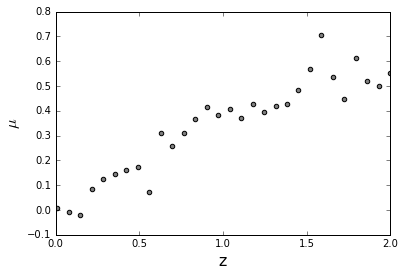

In [83]:
#----------------------------------------------------------------------
# generate data
def cosmo(z):
    return z*z*np.exp(-z)

nData= 30
z = np.linspace(0.01, 2, nData)
mu = np.array(list(map(cosmo, z))) + np.random.normal(scale=0.06, size=len(z))


#define the gaussian functions and their centers/widths
def gaussian_basis(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)

nGaussians = 30 
centers = np.linspace(0, 1.8, nGaussians)
widths = 0.2

plt.scatter(z, mu, s=20, c='gray')
plt.xlim([0., 2.])
plt.xlabel('z',fontsize=16)
plt.ylabel('$\mu$',fontsize=16);